# **Modelos de Predicción de Seguidores para la cuenta ProfeKyle**

### Importar Librerías

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor,export_graphviz, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn import tree
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import pickle

Leer los datasets

In [3]:
data=pd.read_csv('posts_profekyle.csv')
df_emotions=pd.read_csv("df_emotions_caption_profekyle.csv", usecols=["id","timestamp", "Sentiment_Score"])
df_emotions["Sentiment_Score"].value_counts()

Sentiment_Score
 0.000000    1096
 0.500000      46
 0.200000      19
-0.200000      19
-1.000000      18
             ... 
 0.254762       1
 0.017857       1
 0.003125       1
 0.214286       1
 0.003571       1
Name: count, Length: 358, dtype: int64

In [4]:
df_emotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844 entries, 0 to 1843
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1844 non-null   int64  
 1   timestamp        1844 non-null   object 
 2   Sentiment_Score  1844 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 43.3+ KB


Hacer Merge de los datasets

In [5]:
data = data.merge(df_emotions[["id", "Sentiment_Score"]], on="id", how="left")

In [6]:
data["Sentiment_Score"] = df_emotions["Sentiment_Score"]


In [ ]:
# Estimado de variables faltantes, se calcula el estimado de seguidores, con el estimado de interacción
# sobre 0.05 de la tasa promedio de interacción
data["total_seguidores"] = 150000
data["total_interac"] = (data["likesCount"] + data["commentsCount"])
data["tasa_interac"] = (data["total_interac"]/data["total_seguidores"]) * 100
# Calcular la media de engagement_rate
avg_engagement_rate = data["tasa_interac"].mean()

data["seguidoresCount_estimado"] = (data["likesCount"] + data["commentsCount"]) / avg_engagement_rate



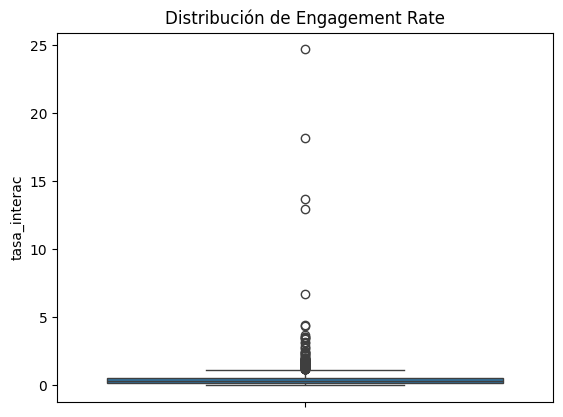

In [9]:
sns.boxplot(data["tasa_interac"])
plt.title("Distribución de Engagement Rate")
plt.show()

In [10]:
Q1 = data["tasa_interac"].quantile(0.25)  # First quartile (25th percentile)
Q3 = data["tasa_interac"].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)


Lower Bound: -0.40933333333333344
Upper Bound: 1.1693333333333333


In [11]:
data = data[(data["tasa_interac"] >= lower_bound) & (data["tasa_interac"] <= upper_bound)]

In [12]:
upper_limit = Q3 + 1.5 * IQR
print("Upper Limit for Engagement Rate:", upper_limit)


Upper Limit for Engagement Rate: 1.1693333333333333


In [13]:
upper_limit = data["tasa_interac"].quantile(0.95)
print("95th Percentile Cap for Engagement Rate:", upper_limit)


95th Percentile Cap for Engagement Rate: 0.9110666666666666


Reemplazar outlier con la mediana

In [15]:
median_engagement_rate = data["tasa_interac"].median()
data["tasa_interac"] = np.where(
    (data["tasa_interac"] < lower_bound) | (data["tasa_interac"] > upper_bound),
    median_engagement_rate,
    data["tasa_interac"]
)

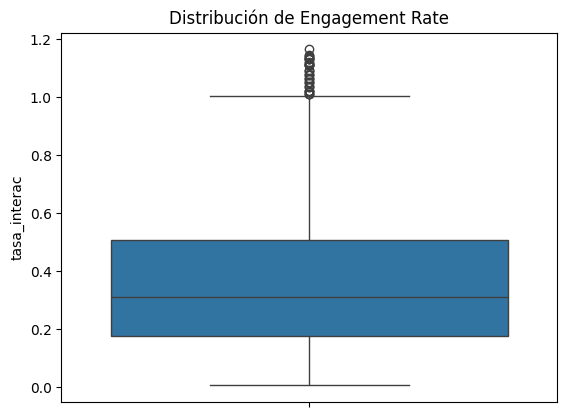

In [16]:
sns.boxplot(data["tasa_interac"])
plt.title("Distribución de Engagement Rate")
plt.show()

In [17]:
print(data[data["tasa_interac"] > 1.0])

                       id                                            caption  \
100   3373299844188010802  La combinación de T+R le da a la T un pronunci...   
131   3327479944525067137  ¿Cómo es la punta de la lengua al hablar con e...   
201   3144275931552744868     ¿Sabes pronunciar bien HOJA DE VIDA en inglés?   
209   3126144441281591827  No agradezcas antes de recibir una respuesta o...   
213   3129043987846760365        No digas ALL THE PEOPLE en inglés americano   
214   3119601562599562116     ¿Qué significa SHIT-FACED en inglés americano?   
238   3090196354725853401  ¿Sabes qué es NOT TOO SHABBY en inglés america...   
239   3088461391639009808  ¿Puedes diferenciar entre WHERE, WEAR, WERE y ...   
260   3058020269895431880  ¿Ya sabes el adjetivo común CLUMSY en inglés?\...   
267   3038340237679178622  ¿Pronuncias EXAMPLE así en inglés?\n\n#pronunc...   
281   3024576639941446652  ‍♂️GONNA y GOTTA no son iguales\n\n#contraccio...   
282   3028198756486446695  ¿Cómo se dice

In [18]:
outliers = data[data["tasa_interac"] > 1.0]


Gráfica de la relación entre Video duración y la tasa de interacción

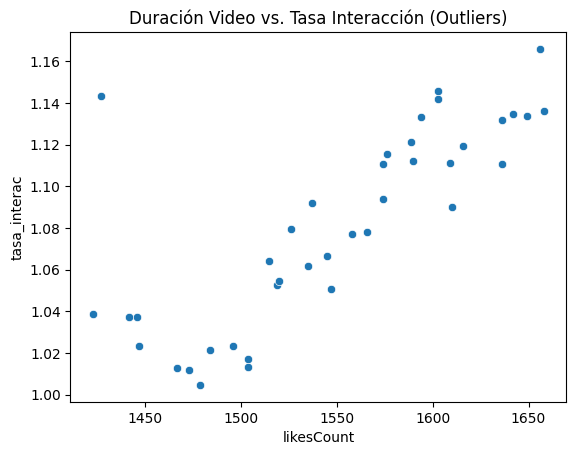

In [19]:
sns.scatterplot(data=outliers, x="likesCount", y="tasa_interac")
plt.title("Duración Video vs. Tasa Interacción (Outliers)")
plt.show()

Conversión de outliers

In [20]:
data["tasa_interac"] = data["tasa_interac"].clip(upper=upper_limit)

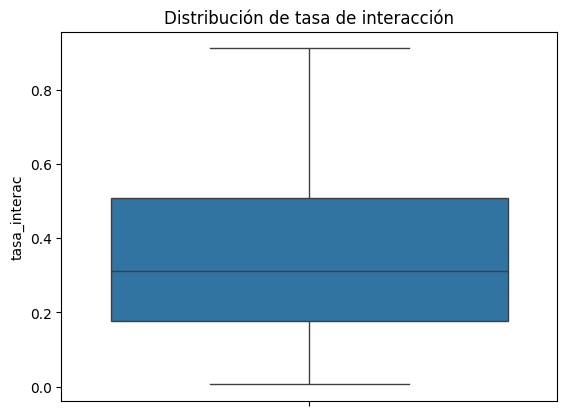

In [21]:
sns.boxplot(data["tasa_interac"])
plt.title("Distribución de tasa de interacción")
plt.show()

Crear columnas calculadas

In [22]:
data["Interaccion_por_videoduracion"] = data["tasa_interac"] / (data["videoDuration"] + 1)

In [23]:
hashtag_columns = [col for col in data.columns if col.startswith("hashtags/")]
data["num_hashtags"] = data[hashtag_columns].apply(lambda row: (row != "-").sum(), axis=1)

# Ensure no missing values in num_hashtags
data["num_hashtags"] = data["num_hashtags"].fillna(0)

In [24]:
data["num_hashtags"].value_counts()

num_hashtags
0     1140
5      272
4       78
3       71
29      67
7       24
6       23
2        9
1        8
15       7
8        6
28       5
9        4
19       3
21       3
27       2
25       2
11       2
12       2
10       1
Name: count, dtype: int64

In [25]:
data1=data.drop(['id','caption','ownerUsername','locationName'], axis=1)

In [26]:
data1.dropna(subset=['firstComment'], inplace=True)

In [27]:
data["interaction_per_hashtag"] = data["tasa_interac"] / (data["num_hashtags"] + 1)


In [28]:
# codificación para el campo categórico 'tipo'
encoder = OneHotEncoder()
tipo_cod = encoder.fit_transform(data[["type"]].fillna("Desconocido")).toarray()
tipo_nombres = encoder.get_feature_names_out(["type"])
tipo_cod_df = pd.DataFrame(tipo_cod, columns=tipo_nombres)
data = pd.concat([data.reset_index(drop=True), tipo_cod_df.reset_index(drop=True)], axis=1)

In [29]:
tipo_cod_df

,type_Image,type_Sidecar,type_Video
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
1724,0.0,0.0,1.0
1725,0.0,0.0,1.0
1726,0.0,0.0,1.0
1727,0.0,0.0,1.0


In [30]:

scaler = StandardScaler()
data["Sentiment_Score"] = scaler.fit_transform(data[["Sentiment_Score"]])

In [ ]:
# Selección de columnas
variablesX = ["likesCount", "commentsCount", "videoPlayCount","videoViewCount","interaction_per_hashtag","Interaccion_por_videoduracion","Sentiment_Score"] 
variablesX

['likesCount',
 'commentsCount',
 'videoPlayCount',
 'videoViewCount',
 'interaction_per_hashtag',
 'Interaccion_por_videoduracion',
 'Sentiment_Score']

In [ ]:
# intervalos de confianza
data["seguidoresCount_estimado"][stats.zscore(data["seguidoresCount_estimado"])>2].sort_values(ascending=True)[0:1]

326    2680.81812
Name: seguidoresCount_estimado, dtype: float64

In [34]:
X = data[variablesX].fillna(0)
y = data["seguidoresCount_estimado"]

Visualización de varianza
VIF < 5: Low multicollinearity (acceptable).
VIF = 5–10: Moderate multicollinearity (investigate further, may need adjustments).
VIF > 10: High multicollinearity (likely problematic, consider removing or combining variables).

In [35]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


[14.288235531747977, 2.237805528060267, 2.046086977526622, 4.47529760009996, 7.439917530420204, 2.5423673998499083, 1.0071683512198024]


In [36]:
X

,likesCount,commentsCount,videoPlayCount,videoViewCount,interaction_per_hashtag,Interaccion_por_videoduracion,Sentiment_Score
0,288,12,3924,1292,0.040000,0.003121,-0.155357
1,296,21,4790,2067,0.042267,0.002924,-0.155357
2,249,27,6854,2561,0.036800,0.002500,-0.155357
3,378,28,7093,2326,0.054133,0.003341,-0.155357
4,546,67,7726,2566,0.081733,0.007287,-0.155357
...,...,...,...,...,...,...,...
1724,85,8,0,2,0.002385,0.001023,-0.155357
1725,97,8,0,1,0.002414,0.001146,0.569885
1726,90,5,0,3,0.004872,0.001037,-0.155357
1727,79,18,0,2,0.064667,0.001083,-0.155357


#Correlación entre columnas a entrenar

In [ ]:
correlation_matrix = data[variablesX].corr()
print(correlation_matrix)

                               likesCount  commentsCount  videoPlayCount  \
likesCount                       1.000000       0.451978        0.360373   
commentsCount                    0.451978       1.000000        0.269593   
videoPlayCount                   0.360373       0.269593        1.000000   
videoViewCount                   0.505767       0.250671        0.554686   
interaction_per_hashtag          0.653838       0.369935       -0.164490   
Interaccion_por_videoduracion    0.379224       0.179276       -0.153384   
Sentiment_Score                  0.018136       0.016416       -0.019058   

                               videoViewCount  interaction_per_hashtag  \
likesCount                           0.505767                 0.653838   
commentsCount                        0.250671                 0.369935   
videoPlayCount                       0.554686                -0.164490   
videoViewCount                       1.000000                -0.045311   
interaction_per_hasht

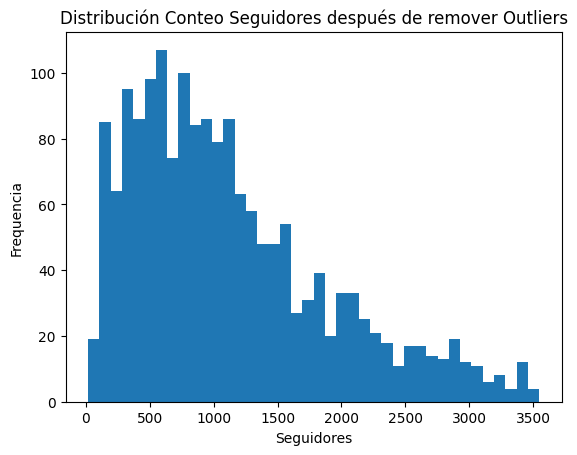

In [38]:
plt.hist(data["seguidoresCount_estimado"], bins=40)
plt.title("Distribución Conteo Seguidores después de remover Outliers")
plt.xlabel("Seguidores")
plt.ylabel("Frequencia")
plt.show()

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Filtrar y entrenar con valores positivos
y_train = y_train[y_train > 0]
X_train = X_train.loc[y_train.index]
print(X_train.shape, y_train.shape)
print(y_train.min())


(1383, 7) (1383,)
18.250652856365736


In [41]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

### Metodos de selección mutual information, permutation para evaluar si las otras columnas añaden valor de predicción

In [42]:
mutual_info = mutual_info_regression(X, y)
feature_importances = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)
print(feature_importances)

interaction_per_hashtag          3.960677
likesCount                       3.293675
Interaccion_por_videoduracion    2.204460
videoViewCount                   0.445802
commentsCount                    0.414678
videoPlayCount                   0.221472
Sentiment_Score                  0.011916
dtype: float64


### Hyperparameter Tuning:

In [43]:
param_grid = {
    "max_depth": [8, 9, 10],
    "min_samples_leaf": [5, 10, 15],
    "min_samples_split": [10, 20, 30]
}
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)
print("Mejores Parametros:", grid_search.best_params_)

Mejores Parametros: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}


# **Árbol de Decisión**

In [44]:
# Train Decision Tree
tree_model = DecisionTreeRegressor(
    max_depth=8,
    min_samples_leaf=5,
    min_samples_split=10,
    random_state=42)
tree_model.fit(X_train, y_train)
tree_predicciones = tree_model.predict(X_test)

### Importancia de las columnas Decision Tree

In [45]:
importances = pd.Series(tree_model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

likesCount                       0.996909
interaction_per_hashtag          0.001701
commentsCount                    0.001321
Interaccion_por_videoduracion    0.000031
videoPlayCount                   0.000023
videoViewCount                   0.000015
Sentiment_Score                  0.000000
dtype: float64


### Evaluación usando Cross-validation

In [46]:
scores = cross_val_score(tree_model, X, y, cv=5, scoring="neg_mean_absolute_error")
print("Cross-Validated MAE:", -scores.mean())


Cross-Validated MAE: 27.616885440726673


In [47]:
train_mae = mean_absolute_error(y_train, tree_model.predict(X_train))
test_mae = mean_absolute_error(y_test, tree_model.predict(X_test))
print(f"Training MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")


Training MAE: 14.17, Test MAE: 22.81


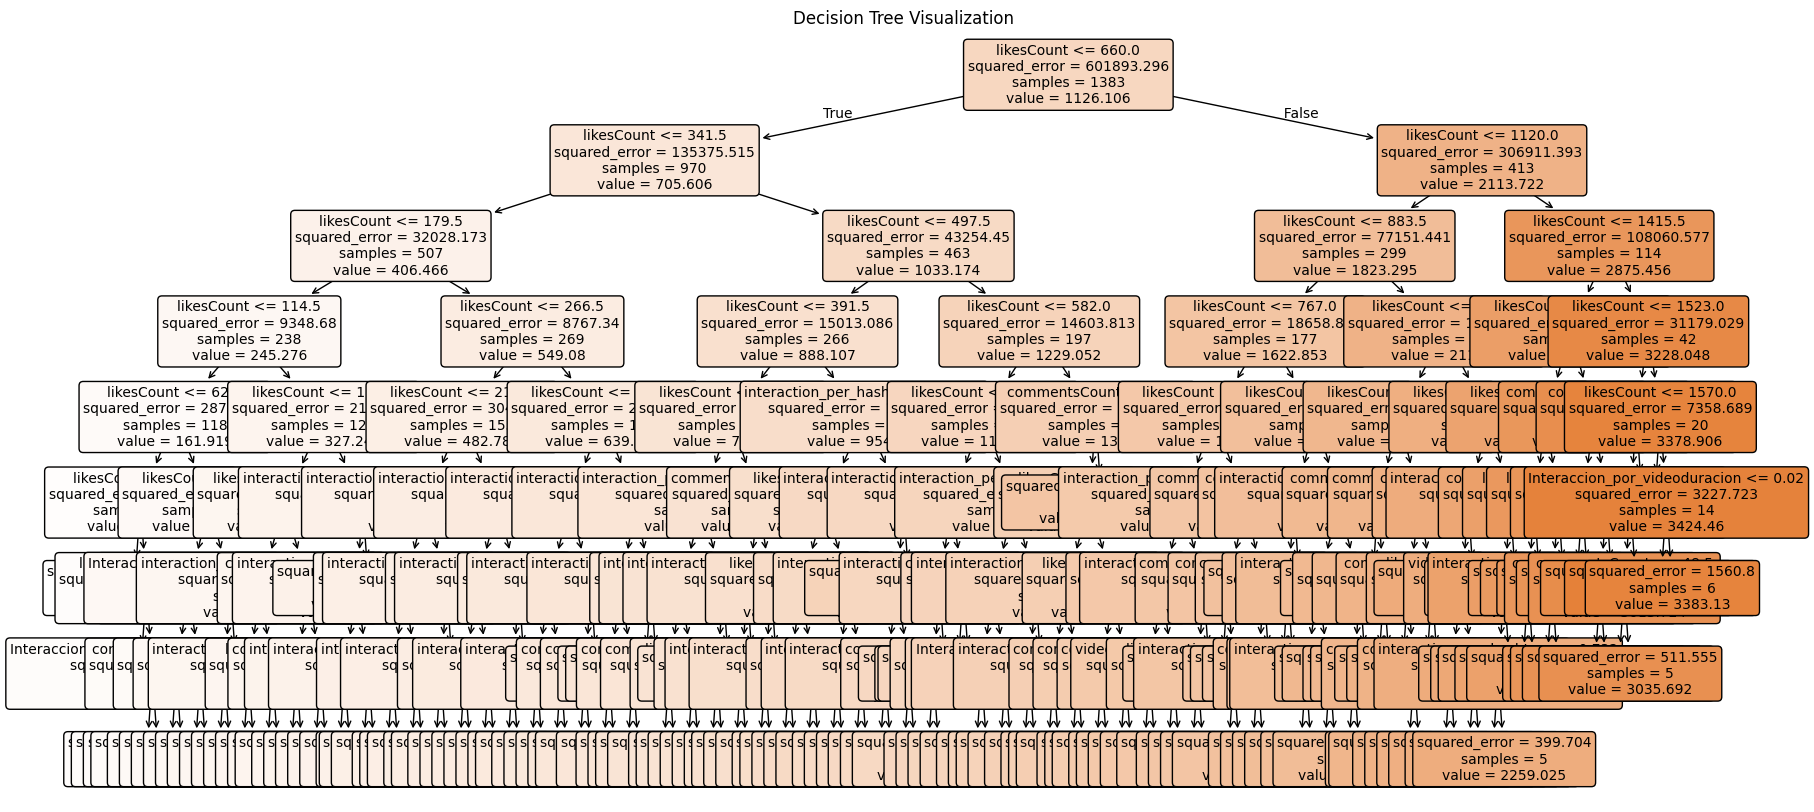

In [48]:
plt.figure(figsize=(20, 10))  # Set the figure size
plot_tree(
    tree_model,
    feature_names=variablesX,  # Use the feature names for better readability
    filled=True,            # Color the nodes by their output values
    rounded=True,           # Round the node boxes for better aesthetics
    fontsize=10             # Adjust font size
)
plt.title("Decision Tree Visualization")
plt.show()

# **Random Forest**

In [49]:
# Random Forest
rf_model = RandomForestRegressor(max_depth=10, n_estimators=100, min_samples_leaf=2, min_samples_split=2, random_state=42)
rf_model.fit(X_train, y_train)
rf_predicciones = rf_model.predict(X_test)


### Validación Cruzada

In [50]:
scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Cross-Validated MAE:", -scores.mean())


Cross-Validated MAE: 17.64976224338423


### Curvas de aprendizaje para evaluar el sobreajuste o el subajuste.

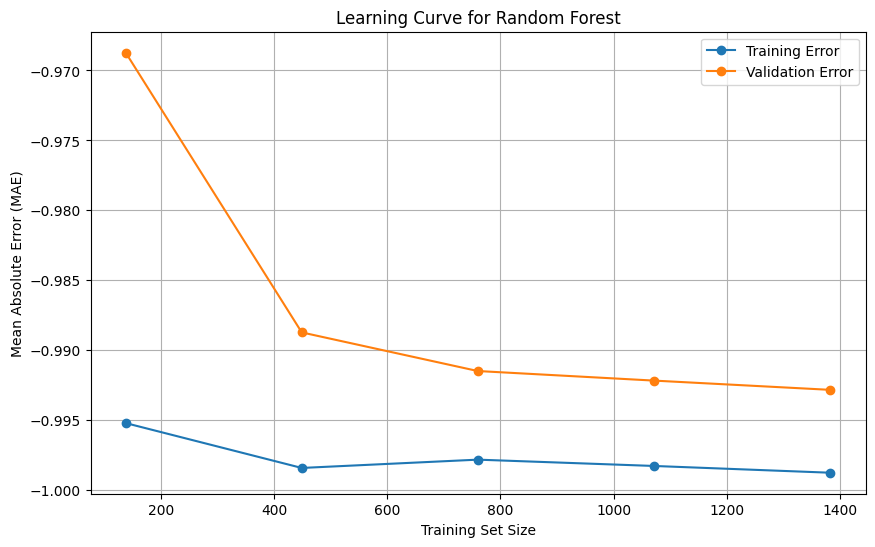

In [51]:
train_sizes, train_scores, test_scores = learning_curve(rf_model, X, y, cv=5)
# Convert scores to positive (MAE)
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Error", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Validation Error", marker='o')
plt.title("Learning Curve for Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend(loc="best")
plt.grid()
plt.show()


### Buscar los mejores parámetros para RandomForest

Mejores Parámetros: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

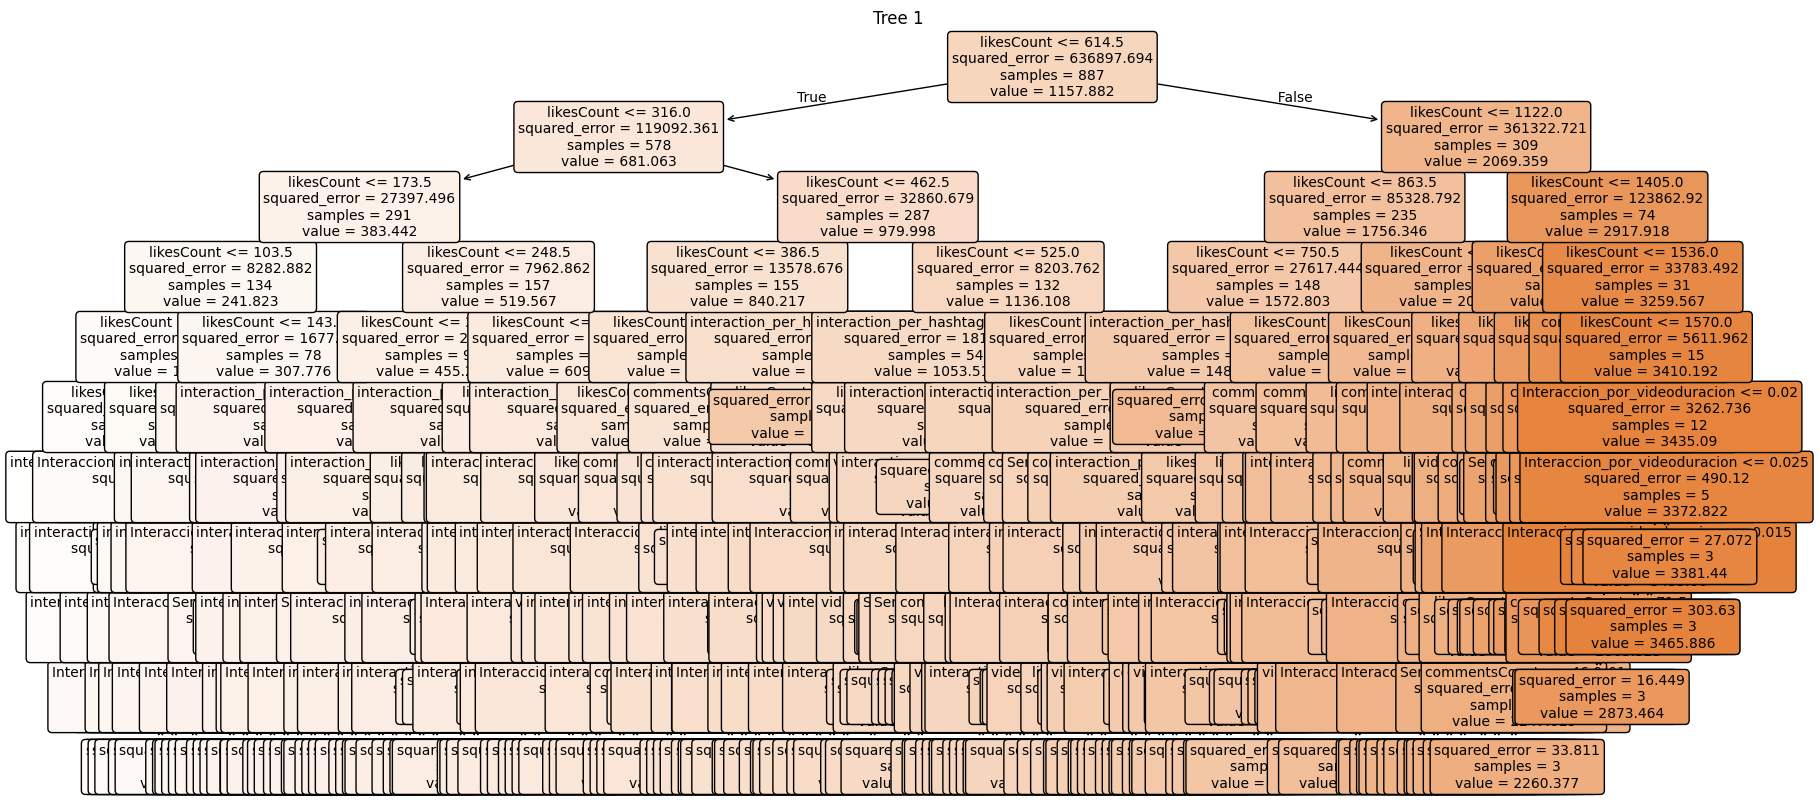

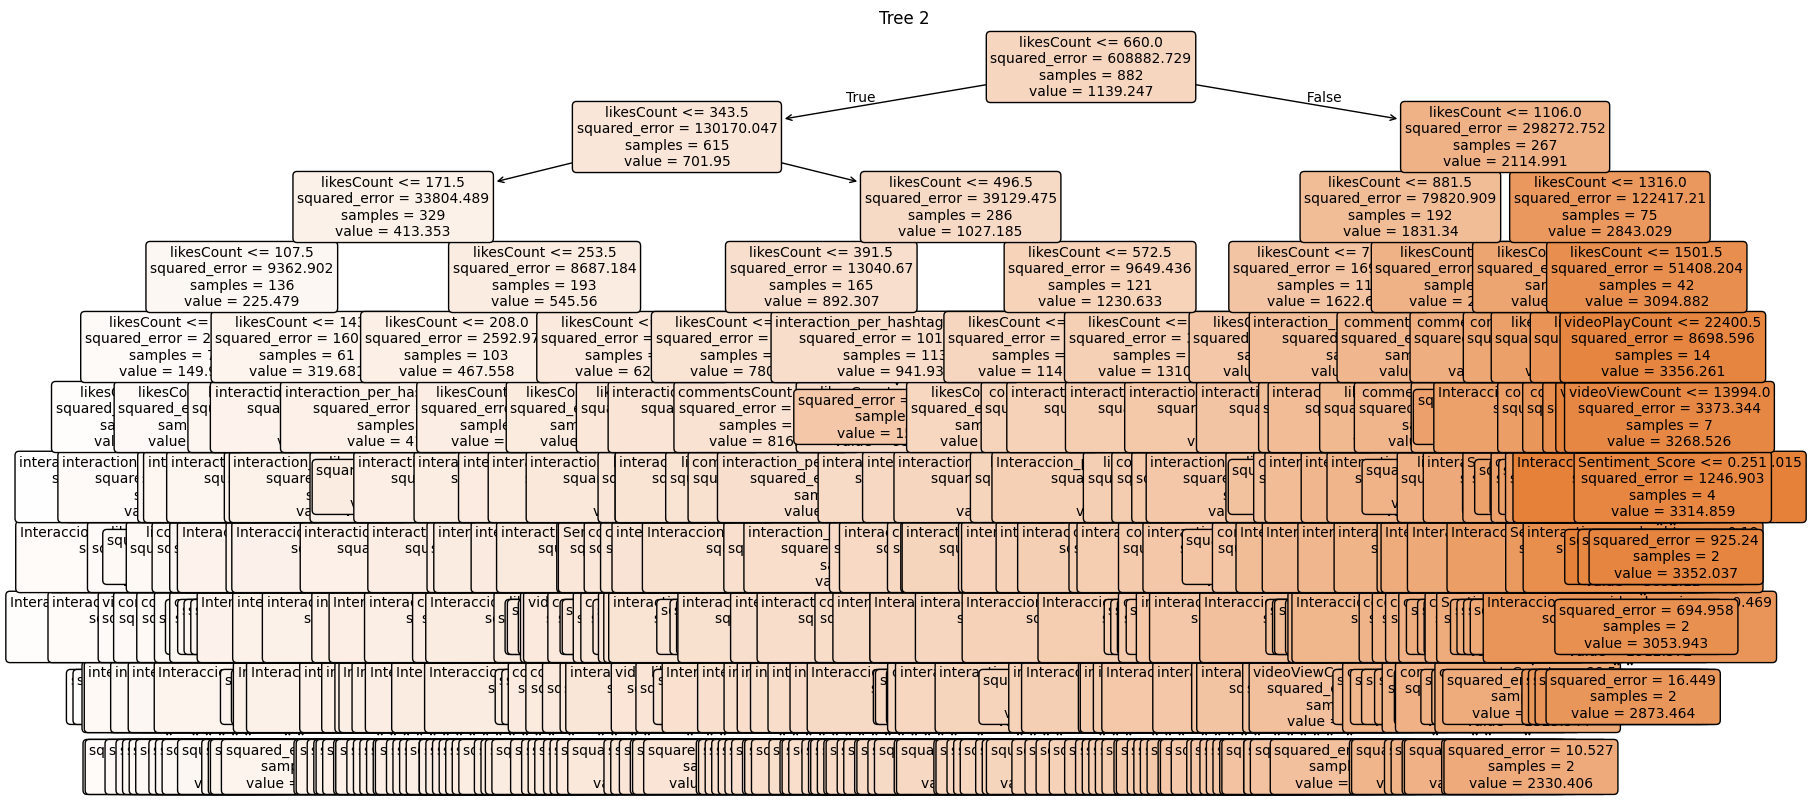

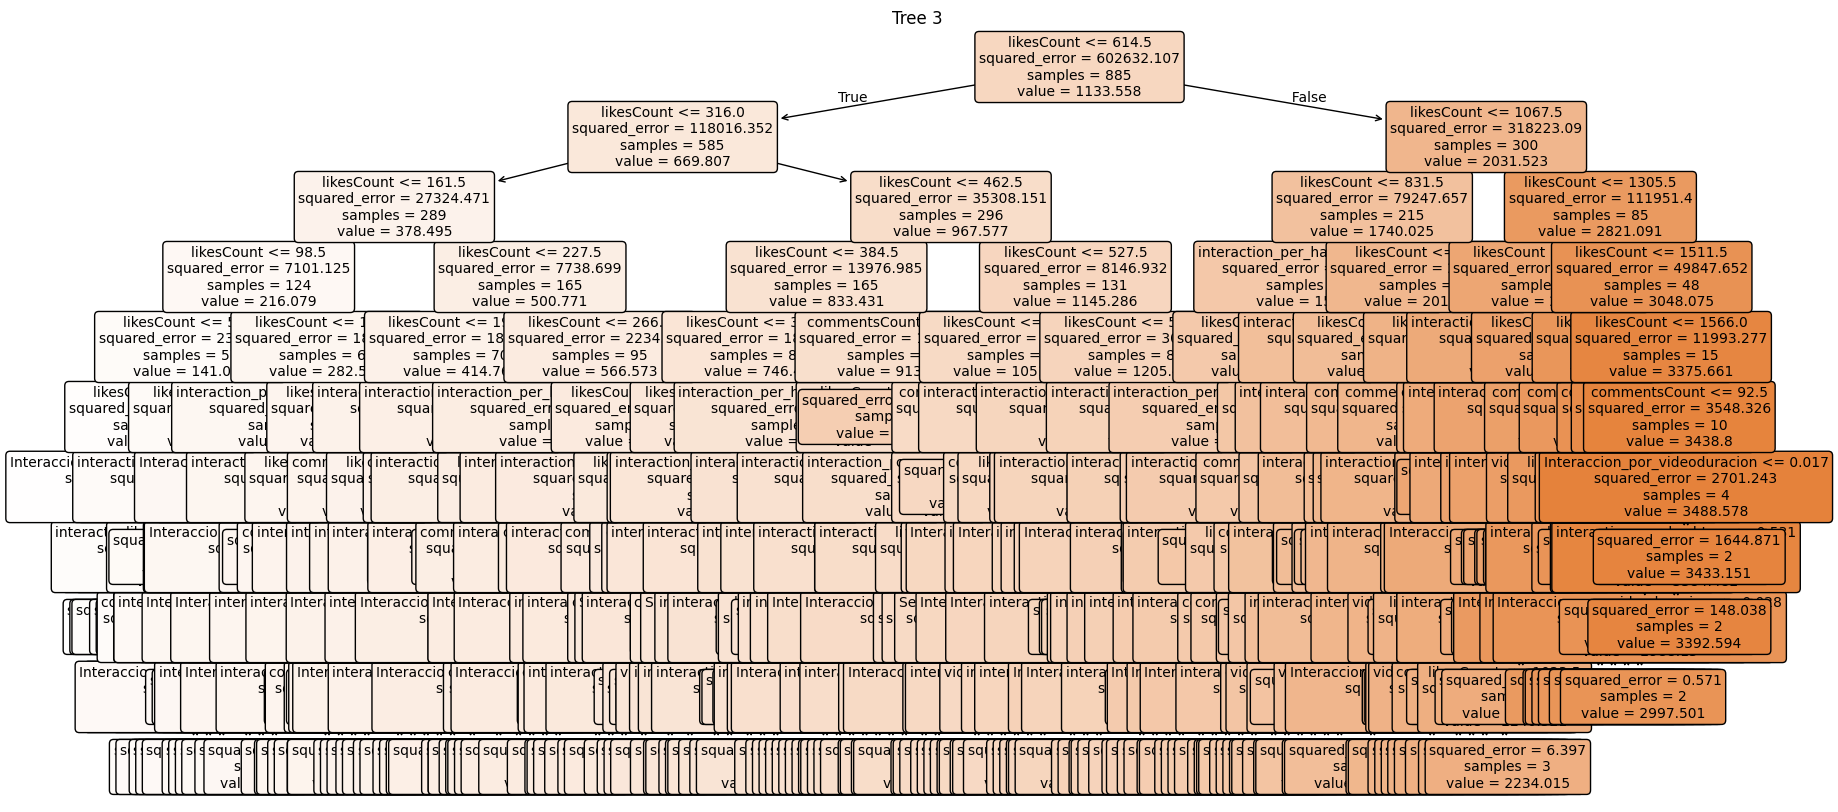

In [53]:
for i, tree in enumerate(rf_model.estimators_[:3]):  # visualiza los primeros 3 árboles
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=X_train.columns, filled=True, rounded=True, fontsize=10)
    plt.title(f"Tree {i + 1}")
    plt.show()


### Importancia de las columnas en Random Forest

In [54]:
# Feature Importance
importances = pd.Series(rf_model.feature_importances_, index = X.columns)
print(importances.sort_values(ascending=False))

likesCount                       0.996182
interaction_per_hashtag          0.002030
commentsCount                    0.001199
Interaccion_por_videoduracion    0.000392
videoPlayCount                   0.000097
videoViewCount                   0.000075
Sentiment_Score                  0.000025
dtype: float64


# **Modelo XGBoost**

In [55]:
# XGBoost
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model = XGBRegressor(
    max_depth=8,               # Maximum tree depth
    n_estimators=100,          # Number of trees
    learning_rate=0.05,         # Learning rate
    random_state=42,
    eval_metric="mae",
    early_stopping_rounds=10 
)
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)
xgb_predicciones = xgb_model.predict(X_test.to_numpy())

[0]	validation_0-mae:591.51756	validation_1-mae:571.16582
[1]	validation_0-mae:562.38639	validation_1-mae:543.17256
[2]	validation_0-mae:534.68530	validation_1-mae:516.23283
[3]	validation_0-mae:508.33644	validation_1-mae:490.80639
[4]	validation_0-mae:483.29401	validation_1-mae:466.64473
[5]	validation_0-mae:459.49532	validation_1-mae:443.95574
[6]	validation_0-mae:436.89627	validation_1-mae:422.21988
[7]	validation_0-mae:415.43519	validation_1-mae:401.50227
[8]	validation_0-mae:395.03349	validation_1-mae:381.82863
[9]	validation_0-mae:375.61644	validation_1-mae:363.21022
[10]	validation_0-mae:357.17011	validation_1-mae:345.37481
[11]	validation_0-mae:339.63050	validation_1-mae:328.51821
[12]	validation_0-mae:322.97523	validation_1-mae:312.45373
[13]	validation_0-mae:307.09782	validation_1-mae:297.01889
[14]	validation_0-mae:292.01561	validation_1-mae:282.39582
[15]	validation_0-mae:277.67813	validation_1-mae:268.56414
[16]	validation_0-mae:264.04302	validation_1-mae:255.34461
[17]	va

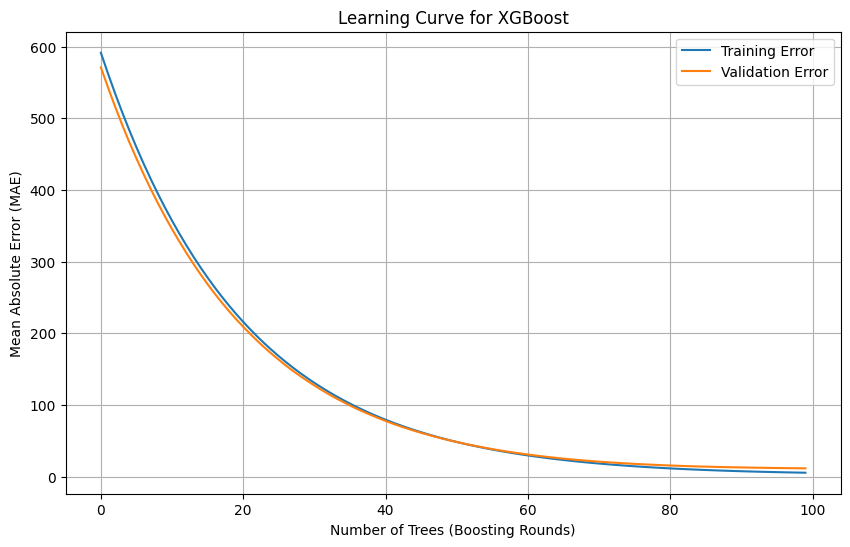

In [56]:

results = xgb_model.evals_result()
epochs = range(len(results["validation_0"]["mae"]))

plt.figure(figsize=(10, 6))
plt.plot(epochs, results["validation_0"]["mae"], label="Training Error")
plt.plot(epochs, results["validation_1"]["mae"], label="Validation Error")
plt.xlabel("Number of Trees (Boosting Rounds)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Learning Curve for XGBoost")
plt.legend()
plt.grid()
plt.show()



### Importancia de las columnas en XGBoost

In [57]:
# Importancia de las Columnas
importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))


likesCount                       0.993991
commentsCount                    0.003274
interaction_per_hashtag          0.002550
videoPlayCount                   0.000060
videoViewCount                   0.000053
Interaccion_por_videoduracion    0.000038
Sentiment_Score                  0.000035
dtype: float32


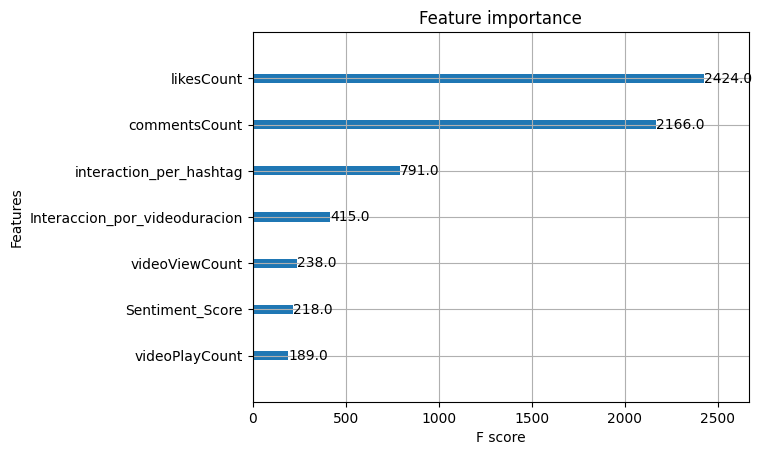

In [58]:
# Plot importance directly
plot_importance(xgb_model, importance_type="weight")  # Options: "weight", "gain", "cover"
plt.show()

## **Evaluación de los módelos**

In [59]:
# Step 4: Evaluación de Modelos
print("Arbol de decisiones MAE:", mean_absolute_error(y_test, tree_predicciones))
print("Random Forest MAE:", mean_absolute_error(y_test, rf_predicciones))
print("XGBoost MAE:", mean_absolute_error(y_test, xgb_predicciones))

Arbol de decisiones MAE: 22.810922952863077
Random Forest MAE: 12.488546456438971
XGBoost MAE: 11.71047073358982


In [60]:
# Step 5: Guardar predicciones
X_test_with_predicciones = X_test.copy()
X_test_with_predicciones["DecisionTree_PredictedFollowers"] = tree_predicciones
X_test_with_predicciones["RandomForest_PredictedFollowers"] = rf_predicciones
X_test_with_predicciones["XGBoost_PredictedFollowers"] = xgb_predicciones

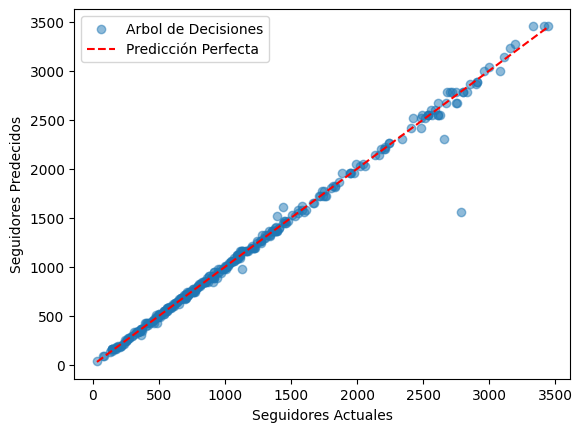

In [61]:

plt.scatter(y_test, X_test_with_predicciones["DecisionTree_PredictedFollowers"], alpha=0.5, label="Arbol de Decisiones")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Predicción Perfecta")
plt.xlabel("Seguidores Actuales")
plt.ylabel("Seguidores Predecidos")
plt.legend()
plt.show()

In [62]:
X_test_with_predicciones["DecisionTree_PredictedFollowers"]

599     1262.047130
1201     676.896436
628     1367.109089
1711     161.214100
1263     600.497175
           ...     
100      748.012265
274     1090.577901
1206     625.972045
101     1186.698006
1084    1051.237605
Name: DecisionTree_PredictedFollowers, Length: 346, dtype: float64

In [63]:
X_test_with_predicciones["DecisionTree_PredictedFollowers"].values

array([1262.04712966,  676.89643594, 1367.10908896,  161.21410023,
        600.49717523, 1262.04712966,   39.54308119, 1074.76066821,
       1576.41963903, 1000.49065033,  161.21410023,  254.21868979,
        720.29243273,  748.0122649 ,  975.87314391, 2545.29012336,
       3272.61243719,  181.34775695,  246.04583851,  303.83957255,
        546.59783555, 1012.76638708,  890.22628933,  769.77198048,
       2998.03184779, 1090.57790068,  254.21868979, 1262.04712966,
        347.43835438,  975.87314391, 2778.91537867,  423.89313956,
       1815.21572695,  553.9411117 , 1368.79896423,  181.34775695,
        679.32985632,  336.21758262, 1116.53438475,  505.54308412,
        347.43835438, 1000.49065033,  367.04090744,  791.40238386,
       2778.91537867,  367.04090744,  553.9411117 ,  367.04090744,
       1318.5533397 ,  336.21758262, 1323.05967374, 1402.11364801,
       2778.91537867, 1393.38664933,  748.0122649 ,  424.07419762,
        890.22628933,   90.49282041,  720.29243273, 1557.72701

In [64]:
print(X_test_with_predicciones)

      likesCount  commentsCount  videoPlayCount  videoViewCount  \
599          587             42               0            5036   
1201         302             21               0               0   
628          628             42               0            5162   
1711          65              6               0               2   
1263         267             31               0               0   
...          ...            ...             ...             ...   
100          354             14            8838            3891   
274          521             27           14253            5837   
1206         296             10               0               0   
101          567             36           12265            4816   
1084         512              4               0               0   

      interaction_per_hashtag  Interaccion_por_videoduracion  Sentiment_Score  \
599                  0.419333                       0.007708        -0.719434   
1201                 0.215333    

In [65]:
# Evaluate Models
tree_mae = mean_absolute_error(y_test, tree_predicciones)
rf_mae = mean_absolute_error(y_test, rf_predicciones)
xgb_mae = mean_absolute_error(y_test, xgb_predicciones)

tree_r2 = r2_score(y_test, tree_predicciones)
rf_r2 = r2_score(y_test, rf_predicciones)
xgb_r2 = r2_score(y_test, xgb_predicciones)



In [66]:
print(f"DecisionTree - MAE: {tree_mae:.2f}, R²: {tree_r2:.2f}")
print(f"Random Forest - MAE: {rf_mae:.2f}, R²: {rf_r2:.2f}")
print(f"XGBoost - MAE: {xgb_mae:.2f}, R²: {xgb_r2:.2f}")



DecisionTree - MAE: 22.81, R²: 0.99
Random Forest - MAE: 12.49, R²: 0.99
XGBoost - MAE: 11.71, R²: 1.00


In [67]:
# Determinar el mejor Modelo
mae_results = {
    "DecisionTree": tree_mae,
    "Random Forest": rf_mae,
    "XGBoost": xgb_mae
}

r2_results = {
    "Arbol de Decisiones": tree_r2,
    "Random Forest": rf_r2,
    "XGBoost": xgb_r2
}

best_mae_model = min(mae_results, key=mae_results.get)
best_r2_model = max(r2_results, key=r2_results.get)



In [68]:
print(f"\nMejor Modelo por MAE: {best_mae_model} (MAE: {mae_results[best_mae_model]:.2f})")
print(f"Mejor Modelo por R²: {best_r2_model} (R²: {r2_results[best_r2_model]:.2f})")



Mejor Modelo por MAE: XGBoost (MAE: 11.71)
Mejor Modelo por R²: XGBoost (R²: 1.00)


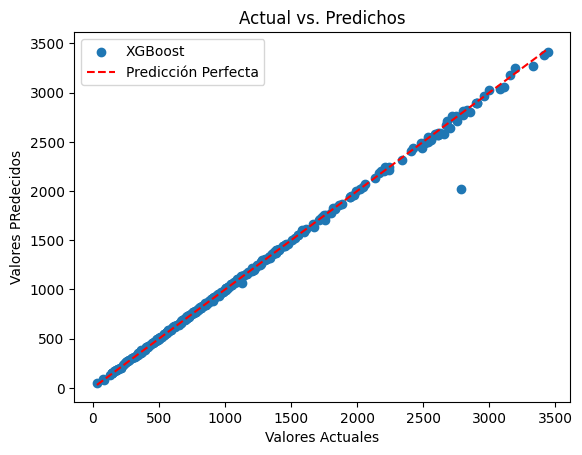

In [69]:
plt.scatter(y_test,X_test_with_predicciones["XGBoost_PredictedFollowers"].values, label="XGBoost")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Predicción Perfecta")
plt.xlabel("Valores Actuales")
plt.ylabel("Valores PRedecidos")
plt.legend()
plt.title("Actual vs. Predichos")
plt.show()


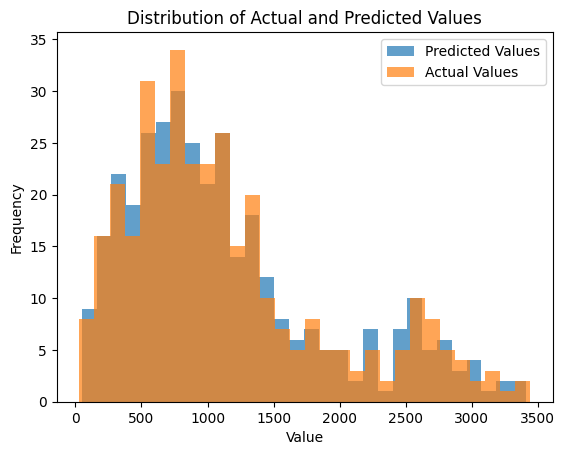

In [70]:
plt.hist(X_test_with_predicciones["XGBoost_PredictedFollowers"].values, bins=30, alpha=0.7, label="Predicted Values")
plt.hist(y_test, bins=30, alpha=0.7, label="Actual Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Actual and Predicted Values")
plt.show()


In [71]:
# Guardar el modelo de Árbol de Decisión
with open('tree_model.pkl', 'wb') as file:
    pickle.dump(tree_model, file)

# Guardar el modelo de Random Forest
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

# Guardar el modelo de XGBoost
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)


In [74]:
# Guardar el DataFrame 'data' como un archivo CSV
data.to_csv('data.csv', index=False)
